In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow.keras as keras

In [4]:
# Loading the cleaned DS 
df = pd.read_csv('cleaned_data.csv')
df.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,Load_Type_Maximum_Load,Load_Type_Medium_Load,time_minutes_sin,time_minutes_cos,month_sin,month_cos
0,3.17,2.95,0.0,0,0,0.065403,0.997859,0.5,0.866025
1,4.00,4.46,0.0,0,0,0.130526,0.991445,0.5,0.866025
2,3.24,3.28,0.0,0,0,0.195090,0.980785,0.5,0.866025
3,3.31,3.56,0.0,0,0,0.258819,0.965926,0.5,0.866025
4,3.82,4.50,0.0,0,0,0.321439,0.946930,0.5,0.866025


In [5]:
df.shape

(26280, 9)

In [9]:
# In Explor_Prepro notebook the DS is preprocessed.  
# In this notebook, I will build Deep Learning model to predict the energy consumption.

# The DS has 26280 and 9 columns. The target value is Usage_KWh, it is right skewed.
# I am going to handle the scaling, hyperparameter search, model building and finally evaluation my model.

In [6]:
# Picking up the target and features
X = df.drop('Usage_kWh', axis=1)
y = df['Usage_kWh']


# I can not use random splitting, because the DS is time series
n = len(X)
# Calculating where the training data should end
train_end = int(n*0.80)
# Calculating where the val data should end
val_end = train_end + int(n*0.10)  
# Taking first 80% of the DS for training
X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
# Taking next 10% of the DS for val 
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
# Taking last 10% of the DS for test
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]
# Source: https://stackoverflow.com/questions/50879915/splitting-data-using-time-based-splitting-in-test-and-train-datasets

In [7]:
print('Shape of training data:', X_train.shape, y_train.shape)
print('Shape of validation data:', X_val.shape, y_val.shape)
print('Shape of test data:', X_test.shape, y_test.shape)

Shape of training data: (21024, 8) (21024,)
Shape of validation data: (2628, 8) (2628,)
Shape of test data: (2628, 8) (2628,)


In [8]:
# Scaling my data
# For scaling, there are many techniques:
# Standard scaler, all features are centered around 0.0
# Min Max scaler, the range is (0-1), it is good for bounded data, but my DS is skewed
# RobustScaler can handle skewed data and outliers

# In my case, RobustScaler is a good choice for handling outliers.

# I dont need to scale time columns because they are already between -1 and 1
# So I will use RobustScaler for normal features
time_columns = ['time_minutes_sin', 'time_minutes_cos', 'month_sin', 'month_cos']
normal_features = [col for col in X_train.columns if col not in time_columns]
preprocessor = ColumnTransformer(transformers=[('robust', RobustScaler(),
    normal_features)],remainder='passthrough')
# Source: https://medium.com/@vinodkumargr/11-column-transformer-in-ml-sklearn-column-transformer-in-machine-learning-48479f8cb48f
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)


<center><h2> Designing the Neural Network Architecture</center>

In [9]:
# Since there is not fixed formula to find perfect number of hidden layers and neurons.
# I need to clean the DS as much as possible and then experiment with hyperparameters.
# More layers and neurons can handle more complex data but the chance of overfitting is higher.
# Less layers and neurons make the model underfit.

# Good strategy for me is to start simple
# I will start with three layers. 128, 64 and 64 neurons. L2 and Dropout are for overfitting
# I will use ReLU for the hidden layers, it helps to learn non linearity, because in DS some columns might have non linear connection to each others
# I wont use sigmoid and softmax in output layer, because they are for classification
# The output can be unrestricted, So model can predict any range of values freely
# Now, let's implement

model = Sequential()
# Input layer
model.add(Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0002), input_shape=(X_train.shape[1], )))
# Hidden layer
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.05))
# Output layer
model.add(Dense(1))

# I created fully connected layers with 128, 64 and 64 neurons
# X_train shape is 8
# The output neuron is 1, because there is only one value to predict
model.summary()

d:\ML&DE\Deep_Learning\.venv\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,633 (53.25 KB)

 Trainable params: 13,633 (53.25 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Until this point, I defined the structure but I did not tell Keras how to train the model
# Before training, I need to compile the model with loss function and optimizer
# Loss function is for regression problem, MSE is kind of common choice
# Since I have skewed distribution, and MSE is sensitive to outliers.
# I have a nother option, which is MAE. In my case, I will use MSE.
# It is smoother, training with MSE will try to reduce large errors

# Optimizer is the algorithm that adjust the network weights to minimize the loss
# I have several options for optimizers in Keras
# SGD, RMSProp, Adam. 
# I will use Adam


# Now I can compile the model, MSE loss, Adam optimizer, I can use MAE as metrics 
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
        epochs=300,batch_size = 128,callbacks=[early_stop], verbose=1)

Epoch 1/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 342.1194 - mean_absolute_error: 9.7272 - val_loss: 52.5078 - val_mean_absolute_error: 4.3362
Epoch 2/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 71.0386 - mean_absolute_error: 4.5618 - val_loss: 44.8462 - val_mean_absolute_error: 3.7580
Epoch 3/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.9348 - mean_absolute_error: 4.1571 - val_loss: 42.5801 - val_mean_absolute_error: 3.4232
Epoch 4/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61.9465 - mean_absolute_error: 3.9709 - val_loss: 41.1847 - val_mean_absolute_error: 3.3974
Epoch 5/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.9001 - mean_absolute_error: 3.8802 - val_loss: 36.7308 - val_mean_absolute_error: 3.0487
Epoch 6/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.2318 - mean_absolute_error: 3.8437 - val_loss: 35.5612 - val_mean_absolute_error: 3.0426
Epoch 7/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57.9600 - mean_absol

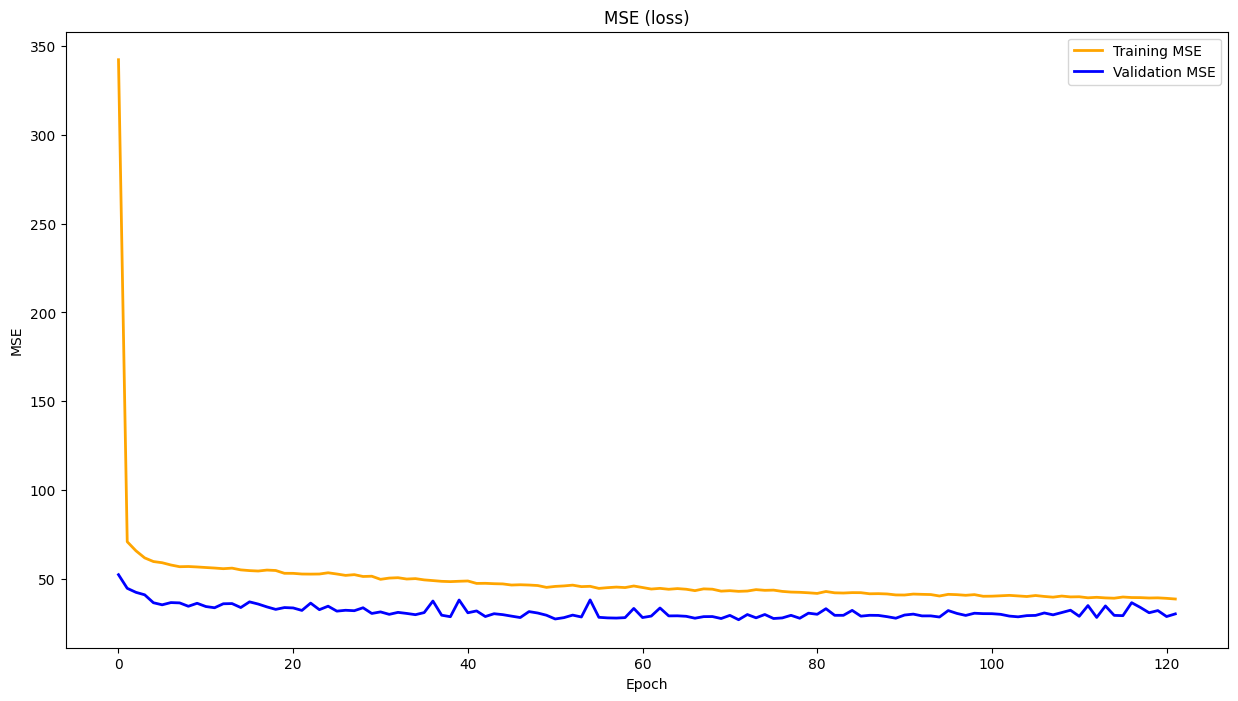

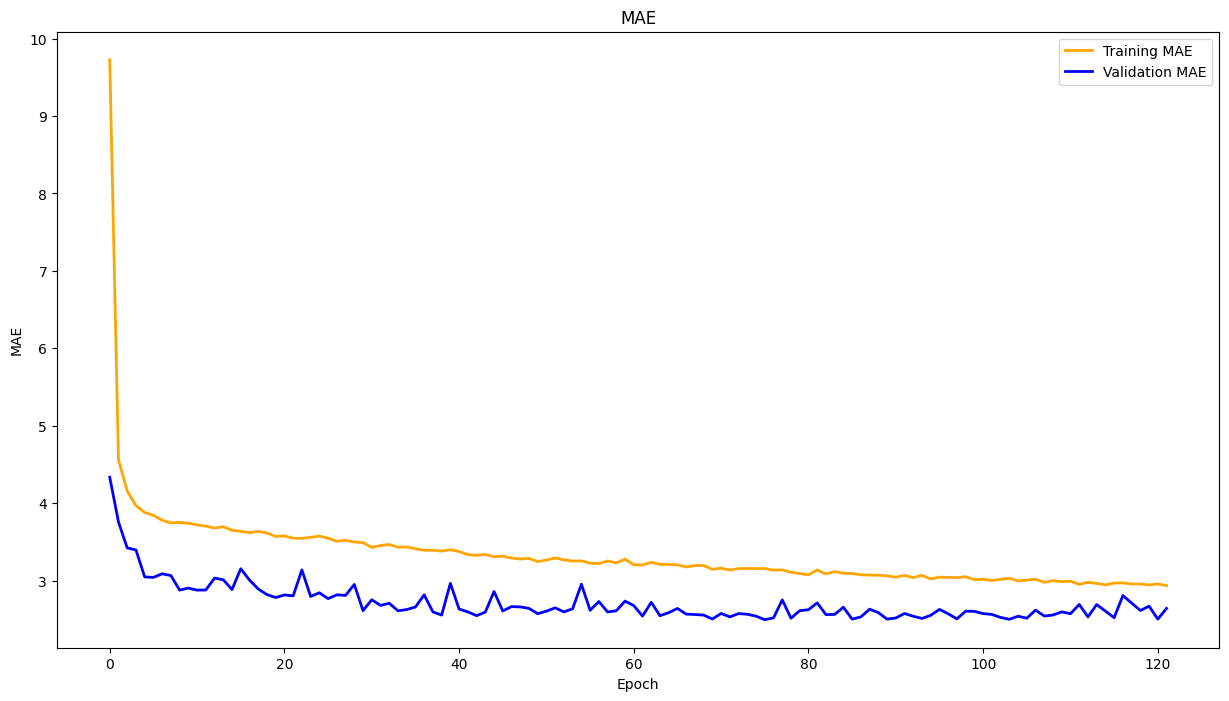

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['loss'], label='Training MSE', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_loss'], label='Validation MSE', color='blue', linewidth=2, markersize=6)
ax.set_title('MSE (loss)')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['mean_absolute_error'], label='Training MAE', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_mean_absolute_error'], label='Validation MAE', color='blue', linewidth=2, markersize=6)
ax.set_title('MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('MAE')
ax.legend()

In [17]:
# MAE is 2.4 Kwh is kind of acceptable, which means the model can monitor energy consumption.
# Model does not overfit.

In [ ]:
# Making predictions:
y_pred = model.predict(X_test)
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


In [ ]:
metrics = {'MSE': mse,'RMSE': rmse,'MAE': mae,'R²': r2}
print("Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Metrics:
MSE: 12.8310
RMSE: 3.5820
MAE: 1.7731
R²: 0.9770


In [20]:
# It seems that the model is trained well.
# R2 shows that the model explains 97.4 % of the variance in energy usage.
# MAE is 1.91 kWh, the model predicts by average 1.91 kWh error.

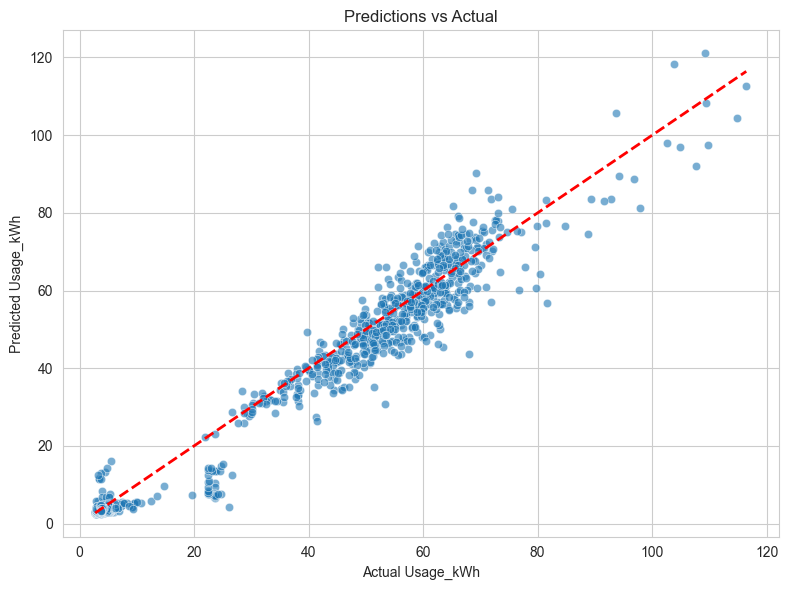

In [27]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred.flatten(), alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Usage_kWh')
plt.ylabel('Predicted Usage_kWh')
plt.title('Predictions vs Actual')
plt.tight_layout()
plt.show()

<center><h2>Hyperparameter Tuning the ANN Model<h2></center>

In [ ]:
# After defining the model architecture and I picked the hyperameter manually.
# Now I am going to use Keras Tuner to find the best hyperparameters for my model.
# There are many algorithms for searching hyperparameters, Grid Search, Random Search, and Bayesian Optimization 
# I will use Bayesian Optimization, it uses past trail results to choose the next hyperparams

def ann_model(hp):
    model = Sequential()
    # Here I will define number of layers and neurons
    # 2-4 Hidden layers and 16 - 256 neurons
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(layers.Dense(units = hp.Int(f'layers_{i}', min_value=16, max_value=256, step=16),
                               activation = hp.Choice('activation', values=['relu', 'tanh'])))
        
        # let's tune dropout 
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer (outside the loop)
    model.add(layers.Dense(units=1))

    
    # Tuning Optimizer and learning rate 
    learning_rate_tune = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')
    # The tuner will try each one to see which works best for energy DS
    optimizer_tune = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
   # Since each optimizer handles learning rates differently, I need to set the learning rate for each one
    if optimizer_tune == 'adam':
        optimizer = Adam(learning_rate=learning_rate_tune)
    # RMSprop adjusts it based on recent gradients
    elif optimizer_tune == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate_tune)
    else:
        optimizer = SGD(learning_rate=learning_rate_tune)
    # Compiling the Model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model



# Searching 
tuner = kt.BayesianOptimization(
    ann_model,
    objective='val_loss',
    max_trials=20, 
    directory='tuner_results',
    project_name='steel_energy')

# Searching for best hyperparameters
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[keras.callbacks.EarlyStopping(patience=5)],
    verbose=1
)

# Getting best model and hyperparameters:
# Finding the one with the lowest validation loss
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hyperparameters)

In [291]:
tuned_params =  best_hyperparameters.values
tuned_params = pd.DataFrame.from_dict(tuned_params, orient='index').reset_index()
tuned_params

,index,0
0,num_layers,2
1,layers_0,256
2,activation,tanh
3,dropout_0,0.2
4,layers_1,192
5,dropout_1,0.1
6,optimizer,adam
7,learning_rate,0.000314
8,layers_2,32
9,dropout_2,0.1
